# Lab Session 6: Signal Averaging and Confidence Intervals
## Auditory Computation, Modelling and Devices (E092970A)
### Dept of Information Technology (UGent) and Dept of Electronics and Informatics (VUB)
Sarah Verhulst

<font color=blue>Students names and IDs: </font> Cesar Zapata - 02213600 <Br> 
<font color=blue>Academic Year </font>: 2021-2022

In [1]:
#run this first before you start
import os
import mat73
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors as colors
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import scipy.io
import scipy.signal as sig
import statsmodels

# Part 1: Auditory Brainstem Response (ABR)

### Auditory EEG for hearing diagnostics

Here, we will make use of the event-related potentials (EEG) to a sensory event. We use multiple repetitions to the same event to improve the signal-to-noise ratio of the data. We will use this information to perform bootstrapping-based hypothesis testing. In the first part, you will process your own recorded auditory brainstem responses (ABRs), which were recorded to 3000 repetitions of an acoustic click. The resulting signal has a very typical waveform with distinct peaks which occur within the first 10 ms after the click onset, and which resemble different processing stages along the auditory pathway. The peak at 1-2 ms (wave-I) reflects the ensemble of auditory-nerve fibers available, whereas the peak at 5-7 ms (wave-V) reflects the brainstem processing of sound (inferior colliculus). The ABR is hence some sort of impulse response of the ear, and is often clinically used to detect peripheral brain lesions, or as a screening tool for neonates. The signal also has information about how the ear processes sound (i.e. for research purposes).

<img src="ABRsetup.png" style="height:400px">

ABR stimuli were clicks of 80 and 100 dB SPL, which were repeated 3000 times. The clicks were presented in opposite polarity, which means that first a positive click was presented, then a negative one, and so forth. Four files were extracted from each of your recordings and are included in the EEG_data folder, e.g. for an ABR recorded with an 80 dB SPL click:

1. ABR_80_Cz: recorded signal from the electrode placed on the top of head (i.e. the B16 electrode as you saw in the lab session)  
2. ABR_80_ref1: recorded signal from the left earlobe electrode (i.e. the external electrode that you placed on the left ear)
3. ABR_80_ref2: recorded signal from the right earlobe electrode (i.e. the external electrode that you placed on the right ear)
4. TrigsABR_80: trigger signal which indicates the onset of each epoch by "1". Odd epochs correspond to positive polarity stimuli and even epochs to negative polarity.

The same definition holds for the rest of the recorded conditions (ABR_100, SAM_EFR, david), recorded using the different stimuli. The files containing "group_stimulus" in their name correspond to the recordings made with each group's pre-designed stimuli.

Run the following code to extract your data from the recording.

In [2]:
#Load in the data

# ABRData80 = mat73.loadmat(os.path.join("C:\\Users\\cesar\\Documents\\UGent\\2022_2023\\Second_Term\\Auditory_computation\\EEG_data\\2023_measurement", "ABR_80_Cz.mat"))
# ABR80_ref1 = mat73.loadmat(os.path.join("C:\\Users\\cesar\\Documents\\UGent\\2022_2023\\Second_Term\\Auditory_computation\\EEG_data\\2023_measurement", "ABR_80_ref1.mat"))
# ABR80_ref2 = mat73.loadmat(os.path.join("C:\\Users\\cesar\\Documents\\UGent\\2022_2023\\Second_Term\\Auditory_computation\\EEG_data\\2023_measurement", "ABR_80_ref2.mat"))
# TrigsABR_80 = mat73.loadmat(os.path.join("C:\\Users\\cesar\\Documents\\UGent\\2022_2023\\Second_Term\\Auditory_computation\\EEG_data\\2023_measurement", "ABR_80_Cz.mat"))

ABRData80 = scipy.io.loadmat(os.path.join("C:\\Users\\cesar\\Documents\\UGent\\2022_2023\\Second_Term\\Auditory_computation\\EEG_data\\2023_measurement", "ABR_80_Cz.mat"))
ABR80_ref1 = scipy.io.loadmat(os.path.join("C:\\Users\\cesar\\Documents\\UGent\\2022_2023\\Second_Term\\Auditory_computation\\EEG_data\\2023_measurement", "ABR_80_ref1.mat"))
ABR80_ref2 = scipy.io.loadmat(os.path.join("C:\\Users\\cesar\\Documents\\UGent\\2022_2023\\Second_Term\\Auditory_computation\\EEG_data\\2023_measurement", "ABR_80_ref2.mat"))
ABR80_trig = scipy.io.loadmat(os.path.join("C:\\Users\\cesar\\Documents\\UGent\\2022_2023\\Second_Term\\Auditory_computation\\EEG_data\\2023_measurement", "TrigsABR_80.mat"))


#here we do all the analysis for the 80dB click stimulus, you should do the same for the 100 dB stimulus as well as
#for the ABR signals that you recorded using your programmed stimuli

#Sampling frequency
FS = 16384
Sig_80 = ABRData80['Ch'] #has the raw recording trace of EEG data
ref1_80 = ABR80_ref1['Ch']
ref2_80 = ABR80_ref2['Ch']


T_80 = ABR80_trig['Trigs'] #is the channel with equal duration of the recording, but which has the trigger events 
#(i.e. sample numbers at which a click was presented)
#find all the triggers
indx_80 = np.where(np.diff(T_80)==1)[1]+1 #index has the sample numbers at which an event started
#We will just average both polarities together, but those interested could also repeat the analysis 
#for only the positive or negative polarity click stimuli by separating the odd and even epochs (trigger indexes).

avg_ref1_ref2 = [(abs(ref1_80[0][i] - ref2_80[0][i]) / 2) for i in range(len(ref1_80[0]))]
re_reference = [(Sig_80[0][i] - avg_ref1_ref2[i]) for i in range(len(ref1_80[0]))]

In [3]:
print(ABRData80.keys())
# print(indx_80)

dict_keys(['__header__', '__version__', '__globals__', 'Ch'])


- Plot the 10-th to 11-th second (one second duration) of the Sig_80 (i.e. the main signal), reference channels (ref1_80 and ref2_80), average of the ref1_80 and ref2_80, and triggers (T_80) in separate figures using plt.subplot to get a feeling of your data. Make titles for each figure, i.e., 'Recorded signal', 'Reference Signal1', 'Reference Signal2', 'Averaged Reference' and 'Trigger signal'. First, define a time vector with a duration of one second and then plot the above-mentioned signals. Assign proper labels for the x and y axes.
- Re-reference the main signal (Sig_80) to the average of the reference channels (ref1_80 and ref2_80) and plot the re-referenced channel in a separate figure (the same time interval, i.e. the 10-th to 11-th second). To apply the re-referencing, subtract the averaged reference channel from the main signal (Sig_80). 

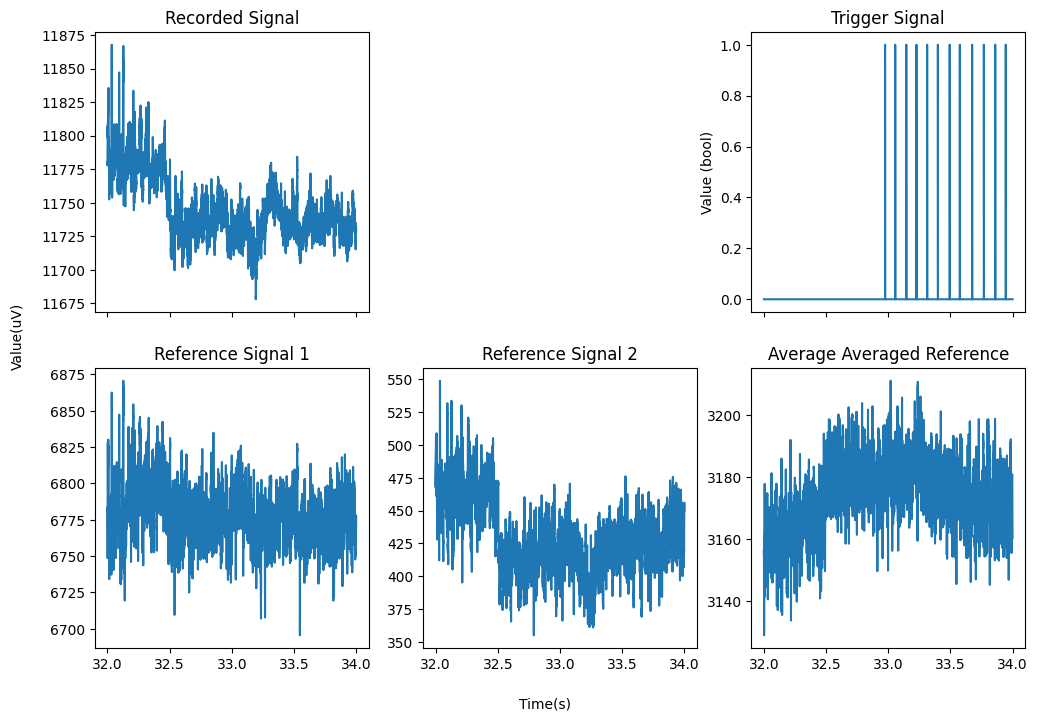

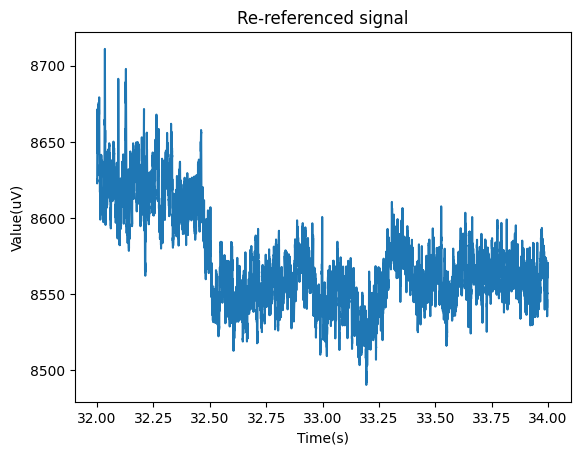

In [4]:
seconds = [32, 34] # trigger starts at 33s

time_10_11 = np.arange(seconds[0], seconds[1], 1/FS) # time array for the desired seconds


# print(ref2_80[0][seconds[0] * FS: seconds[1] * FS])
# print(avg_ref1_ref2[seconds[0] * FS: seconds[1] * FS])


figs, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True)

figs.text(0.5, 0.04, 'Time(s)', ha='center', va='center')
figs.text(0.06, 0.5, 'Value(uV)', ha='center', va='center', rotation='vertical')

axs[0][0].plot(time_10_11, ABRData80['Ch'][0][seconds[0] * FS: seconds[1] * FS])
axs[0][0].set_title("Recorded Signal")

axs[0][2].plot(time_10_11, T_80[0][seconds[0] * FS: seconds[1] * FS])
axs[0][2].set_ylabel("Value (bool)")
axs[0][2].set_title("Trigger Signal")

axs[0][1].axis('off') # leave a blank space in the subplot

axs[1][0].plot(time_10_11, ref1_80[0][seconds[0] * FS: seconds[1] * FS])
axs[1][0].set_title("Reference Signal 1")

axs[1][1].plot(time_10_11, ref2_80[0][seconds[0] * FS: seconds[1] * FS])
axs[1][1].set_title("Reference Signal 2")

axs[1][2].plot(time_10_11, avg_ref1_ref2[seconds[0] * FS: seconds[1] * FS])
axs[1][2].set_title("Average Averaged Reference")

plt.show()

# plotting the re-referenced values
plt.figure(1)
plt.plot(time_10_11, re_reference[seconds[0] * FS: seconds[1] * FS])
plt.title("Re-referenced signal")
plt.xlabel("Time(s)")
plt.ylabel("Value(uV)")
plt.show()

Apply a 4th order butterworth filter (sig.butter) to your data (re-referenced signal) with cut-off frequencies between 100 and 1500 Hz. Use the sig.filtfilt function to design your filters, apply first the HP filter and then afterwards the LP filter. Then, visualize the signal spectrum as well as the time-domain signal before and after filtering (use np.fft.fft).

time: 437.0


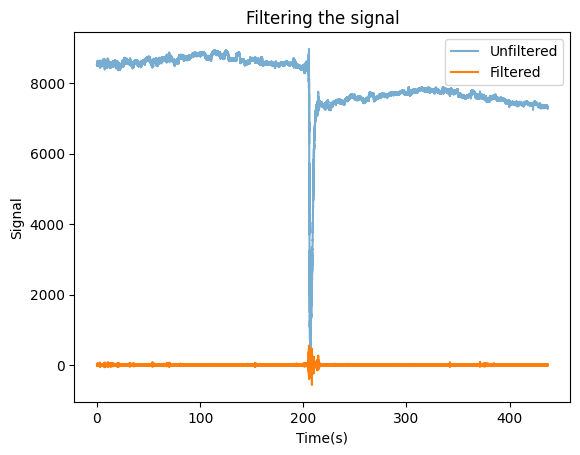

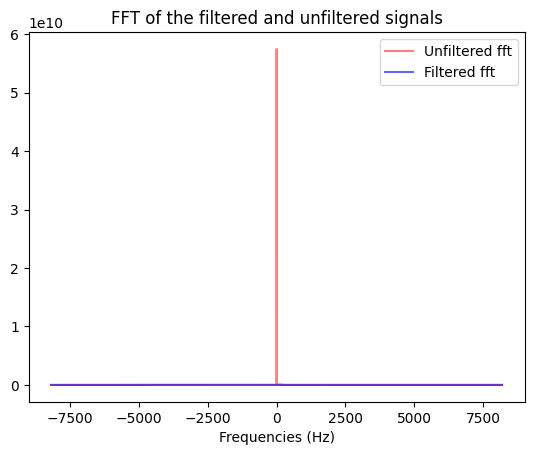

In [5]:
print(f"time: {len(re_reference) / FS}")
time = np.linspace(0, len(re_reference) / FS, len(re_reference))


F_highpass = 100 / (FS/2)
F_lowpass = 1500 / (FS/2)

HP_a, HP_b = sig.butter(4, F_highpass, btype='high')
LP_a, LP_b = sig.butter(4, F_highpass, btype='high')

Filtered_sig = sig.filtfilt(HP_a, HP_b, re_reference)
Filtered_sig = sig.filtfilt(LP_a, LP_b, Filtered_sig)


freq_org = np.fft.fftfreq(len(re_reference), 1/FS) # re_referenced signal
freq_org = np.fft.fftshift(freq_org)

fft_org = np.abs(np.fft.fft(re_reference))
fft_org = np.fft.fftshift(fft_org)

freq_filt = np.fft.fftfreq(len(re_reference), 1/FS) # re_referenced signal
freq_filt = np.fft.fftshift(freq_filt)

fft_filt = np.abs(np.fft.fft(Filtered_sig))
fft_filt = np.fft.fftshift(fft_filt)

# print(f"Filtered: {len(Filtered_sig)}\nFFT: {len(time_domain_org)}")

# plt.plot(time, re_reference)
plt.plot(time, re_reference, alpha=0.6, label="Unfiltered")
plt.plot(time, Filtered_sig, label="Filtered")
# plt.xlim([100, 101])
plt.title("Filtering the signal")
plt.xlabel("Time(s)")
plt.ylabel("Signal")
plt.legend()
plt.show()



plt.plot(freq_org, fft_org, color='r', alpha=0.5, label='Unfiltered fft')
plt.title("FFT of the filtered signal")

plt.plot(freq_filt, fft_filt, color='b', alpha=0.6, label='Filtered fft')
plt.title("FFT of the filtered and unfiltered signals")
plt.xlabel("Frequencies (Hz)")
plt.legend()
# plt.xlim([0, max(freq_org)])

plt.show()

Now it is time to epoch your data into the events, here it is important to cut your signal 5ms before the trigger onset (indx events) and analyse up to 20ms after the trigger event. Count the number of events you will have (len(indx)), and then make a matrix which has dimensions (len(indx) x samples), where samples correspond to a time axis which starts 5 ms before the click (event occurs at 0) and runs 20 ms until after the click. Once you made your epochs, make a figure which plots time vs all your epochs at once (you might have to transpose your matrix to plot using the ".T" function). Afterwards, subtract the mean of each epoch from the same epoch to apply the baseline correction. This visualisation is helpful when determining a threshold above which you will remove "bad" or "noisy" epochs. Here, you will likely only remove 5 or 10 % of the noisiest epochs (the ones with the largest absolute amplitude). Write a code to automatically remove equal number of epochs of each polarity with amplitudes above a reasonable "self-determined" threshold value. Discard the noisy epochs and now compare your epochs before and after noise-rejecting. Did your algorithm work? 


Once you have rejected the noisy epochs,  concatenate the epochs of each polarity and then average the epochs and have a look at the mean ABR waveform (plotted over time). Do you notice the wave-V peak near 6-7 ms?
Perform the same preprocessing steps for the 100 dB ABR data. Compare the wave-1 and 5 peaks and latencies in two ABR recordings (ABR80 and ABR100) and provide your explanation in this regard at the bottom of your code.

NOTE: Regarding the ABR peaks latencies, consider an approximate 1.2 ms offset caused by sound delivery system.


fs: 16384
# of samples in an epoch: 408.6
shape epochs: (3000, 408)


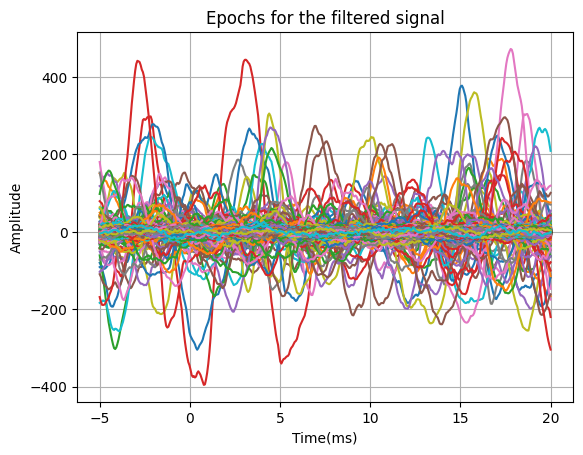

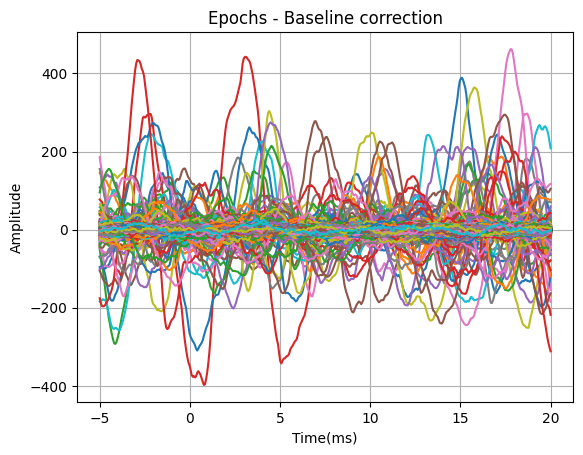

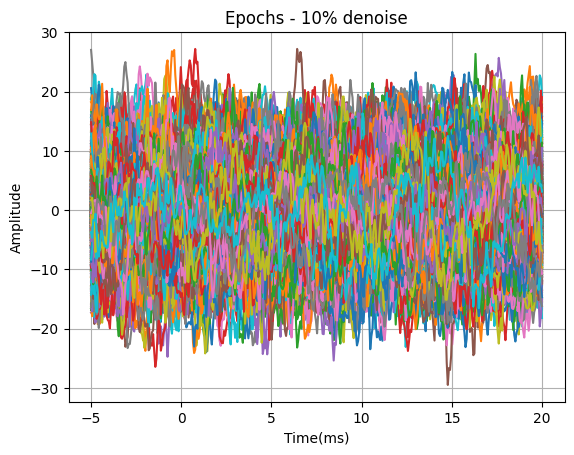

epochs after denoising - 10%: (2700, 408)


In [44]:
'''
- Cut signal: 5ms before trigger onset (indx events) up to 20ms after trigger event. DONE
- Count the number of events you will have (len(indx)) and make a matrix with dimensions (len(indx) x samples) DONE
    -> samples: time axis which starts 5ms before click until 20ms after the click # DONE
- When epochs are done, plot time vs all the epochs at once (may have to transpose matrix with .T function) DONE
- Subtract the mean of each epoch from the same epoch to apply baseline correction. DONE
- Write a code to automatically remove equal number of epochs of each polarity with amplitudes above a reasonable "self determined"
  threshold value (?) -> of each polarity? DONE (?)
- discard the noisy epochs and compare your epochs before and after noise-rejecting. did it work? - maybe to much

- After rejecting noisy epochs, concatenate the epochs of each polarity and then average the epochs and look at the mean ABR waveform (over time)
- Do you notice the wave-V peak near 6-7ms?, provide your explanation in this regard at the bottom of your code

        -- Regarding the ABR peaks latencies, onsider an approximate 1.2ms offset caused by sound delivery system --
'''

# print(indx_80)
# print(max(time))
print(f"fs: {FS}")
FSm = FS / 1000
nsamples_epoch = (25*FSm)-1 # int is 410
print(f"# of samples in an epoch: {nsamples_epoch}")

epochs = np.zeros([len(indx_80), int(nsamples_epoch)]) # rows x columns -> len(indx) x samples
time_epoch = np.linspace(-5, 20, 408)

print(f"shape epochs: {epochs.shape}") # 3000 triggers, 410 samples in 25ms

# creating epochs matrix
for i in range(len(indx_80)):
    click = indx_80[i]
    epochs[i] = Filtered_sig[click - int(5*FSm): click + int(20*FSm)] # from (click - 5ms) to (click + 20ms)
    plt.plot(time_epoch, epochs[i])
plt.xlabel("Time(ms)")
plt.ylabel("Amplitude")
plt.title("Epochs for the filtered signal")
plt.grid()
plt.show()
    

# baseline correction for each epoch
epochs_baseline = [(epoch - np.mean(epoch)) for epoch in epochs]

# plotting every epoch (baseline)
for i in range(len(epochs)):
    plt.plot(time_epoch, epochs_baseline[i])

plt.title("Epochs - Baseline correction")
plt.xlabel("Time(ms)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


# Denoising algorithm
n_epochs = np.array(epochs_baseline).shape[0] # 3000 epochs
sum_epochs = np.zeros(n_epochs)

# summation of every epoch to categorize into the 10% epochs with highest abs amplitudes
for i in range(n_epochs):
    sum_epochs[i] = np.sum(np.abs(epochs_baseline[i][:])) 

sorted_sum_epochs = np.array(np.argsort(sum_epochs))[::-1] # sort in descending order -> want to see indices for the noisiest epochs

percent_to_drop = 0.1 # 10 percent of 3000 -> 300
to_delete = sorted_sum_epochs[ : int(n_epochs * percent_to_drop)] # indices of 10% noisiest epochs


# removing noisy epochs
denoised_epochs = [] 

for i in range(n_epochs):
    if i in to_delete: # if the index is in the list of indices to delete, just go to the next epoch
        continue
    denoised_epochs.append(epochs_baseline[i]) # if the epoch is not on the list "to delete" then it's a good value, append it


# plotting every epoch (baseline)
for i in range(len(denoised_epochs)):
    plt.plot(time_epoch, denoised_epochs[i])

plt.title("Epochs - 10% denoise")
plt.xlabel("Time(ms)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

print(f"epochs after denoising - 10%: {np.array(denoised_epochs).shape}") # 2700 remaining epochs

In [6]:
#your code goes here (ABR_100 analysis)


To perform statistics on the signal peaks of the 80 and 100 dB ABR waveforms, it is necessary to quantify the variability of each of the datapoints in the waveform. You can estimate this variability by using a resampling method which calculates a waveform corresponding to the 5 and 95\% datapoint on each time sample. In this way, you generate a 5% and 95% Confidence Interval (CI) on the data-points of the mean waveform (i.e. approximately corresponding to the standard error of the mean) which you can use to evaluate the significance of waveform feature differences in the two recordings.
- Use the matrix with epochs (after noise-rejection) to generate a 5th and 95th percentile waveform of the 80 or 100 dB . The specific steps include, (i) calculate and store 1000 resampled mean waveforms from the epoch matrix, by randomly sampling epochs (with replacement) from the matrix before you calculate the mean waveform (use np.random.choice to get the random indices, and pick out the corresponding epochs before you calculate the mean signal for each of the 1000 resampling loops).
- After this procedure, you have 1000 mean waveforms over time stored. You can plot your matrix with 1000 mean ABR waveforms (use yourmatrixname.T in case there is a dimension mismatch with your time vector), to see that most mean ABR waveforms preserve the ABR waveform maximum near 5 ms.  

In [7]:
#your code goes here


Next, you can calculate the CI05 and CI95 waveforms out of the (1000 x time sample) matrix with resampled mean signals. To do this, you need to write a for loop that has an equal length as your time vector ("for n in range(0,len(time)):"), and that for each sample, ranks the values from low to high. You can store the indices of ranked values using the "np.argsort" function. Once you did this, you have the indices corresponding to ascending order values for each time sample. Take index numbers [49] and [949] out for each time-sample to generate the CI05 and CI95 waveforms respectively. 
- For the Ch 80 and 100 dB waveforms, plot the mean waveform (before bootstrapping) along with the CI05 and CI95 waveforms on the same plot (with different colors for the 80 and 100 dB condition). You can also modify the following script to plot the confidence interval as a filled area around the mean waveform (but then it is graphically better to plot the results on two figures instead). 
    - plt.show()
    - fig, ax = plt.subplots(1,1,sharex=True)
    - ax.plot(t,xmean,color='k')
    - ax.fill_between(t, CI05[:,0], CI95[:,0],color='C1')
    - plt.show()

In [8]:
#your code goes here


# Part 2: Envelope Following Response (EFR)

The next recording is one from an envelope-following response (EFR). Here the stimulus was a 500-ms long, 70 dB SPL, 4-kHz pure tone which was modulated with a 120 Hz envelope. When the auditory-nerve fibers are intact, the EEG response will follow the stimulus envelope frequency, and hence we need to analyse the strength of the response in the frequency domain. Again, the triggers may be of positive and negative polarity, and you can follow the same steps as of ABR to load in the data and identify the samples at which the onsets occur. Afterwards, plot the Cz channel, reference channels, average of the two reference channels and triggers in different panels of a subplot. Then, similar to ABRs, re-reference the Cz channel recording to the average of the reference channels and plot the result in a separate figure. The labeling of the files is similar to that of the ABRs:

1. SAM_EFR_Cz: recorded signal from the electrode placed on the top of head (i.e. the B16 electrode)
2. SAM_EFR_ref1: recorded signal from the left earlobe electrode
3. SAM_EFR_ref2: recorded signal from the right earlobe electrode
4. TrigsSAM_EFR: trigger signal which indicates the onset of each epoch by "1". Odd epochs were presented with positive polarity and even epochs with negative polarity.


Note: 
- The sampling frequency (FS) is 16384 Hz.
- The stimulus was repeated 1000 times (500 positive and 500 negative epochs)
- Limit the plots' x-axis to the range of 3 seconds (e.g. 10 to 13 seconds).


In [9]:
#your code goes here

Different than for the ABRs, you should apply a filter with cut-off frequencies between 60 and 1000 Hz, and epoch your recordings between 100 ms and 500 ms after the trigger onset to maintain a steady-state response which is not influenced by the offset. You may have a look at the waveform in earlier starting windows too in case you want to observe the onset response.

(1) Plot the signal before and after filtering in separate figures with proper titles. You can use plt.subplot. (2) After epoching, subtract the mean of each epoch from the same epoch to apply the baseline correction.
(3) Plot the extracted epochs. To do it, first, define a time vector according to the duration of your epochs, i.e. 400 ms, convert it to miliseconds and then label the x-axis, properly. Title your plot as "400-ms epochs".
(4)  Repeat the same procedure as the step (2-3), but with epochs of 500 ms, i.e. define your epochs between 0 to 500 ms after the trigger to see the onset response.

Note that you may need to transpose your variables (depending on how you have defined them) before plotting.

In [10]:
#your code goes here

Have a look at the quality of your epochs, and make a piece of code which removes those epochs which have the 10% highest overall amplitude from both the positive and negative epochs, to make sure you remove an equal number of positive and negative epochs to remove epochs with artifacts. To implement it, use the 400-ms epochs in the previous section and drop the 10% of epochs of each polarity with the highest maximum values.

- Plot the sorted maximum values of epochs of each polarity in separate figures. 
- Then remove the 10% of epochs with the highest amplitudes and plot the remained epochs maximum values on top of the figures of the previous step (Do it for both polarities).
- After removing the artifact-contaminated epochs, plot the artifact-free positive and negative epochs in separate figures with proper titles and x-axis labels. How would you interpret the figures? Do you think removing 10% of the noisy epochs was enough or still your epochs contain artifact-contaminated epochs?

In [11]:
#your code goes here

Next, concatenate the positive and the negative epochs, and average the response across all epochs. This is the EFR time-domain waveform, make a time-axis and plot the result (t=0 should correspond to the trigger time).

In [12]:
#your code goes here

Now plot the power spectrum of the EFR (2*abs(fft(X))/length(X)), make a frequency axis and if necessary plot the 20log10 response. After plotting the spectrum, limit your frequency axis to the range of [0-1000] Hz.

Do you notice a peak at 120 Hz? Are there other spectral peaks observed? The size of the spectral peak can be identified as the EFR strength can be related to the fidelity with which the auditory brainstem can track stimulus envelopes. Ageing listeners and listeners with hearing damage may have weaker responses because of synaptopathy (a reduction in the number of auditory-nerve fibers).

In [13]:
#your code goes here

The last recording corresponds to the envelope-following response (EFR) of a word extracted from the Flemish Speech Matrix, to show how EFRs can be extracted for more complex stimuli. The word "David" was used and was monotonized so that its fundamental frequency (F0) is constant over time at ~220 Hz. The stimulus was then high-pass filtered with a cutoff frequency of 1650 Hz and calibrated at 70 dB SPL. For the recording, the stimulus was cut to 500 ms and was repeated 1200 times (600 positive and 600 negative epochs). The EEG response to such a stimulus is expected to follow the fundamental frequency of the original speech. 

The same procedure (as for the modulated tone) can be followed to extract the Cz channel, reference channels and trigger signals, and re-reference the Cz channel recording to the average of the reference channels. For your convenience you can plot everything in the same way as before. The same labelling is followed:

1. david_EFR_Cz: recorded signal from the electrode placed on the top of head
2. david_EFR_ref1: recorded signal from the left earlobe electrode
3. david_EFR_ref2: recorded signal from the right earlobe electrode
4. Trigsdavid_EFR: trigger signal which indicates the onset of each epoch by "1". Odd epochs correspond to positive polarity stimuli and even epochs to negative polarity.

In [14]:
#your code goes here

The same filtering can be applied as in the previous case (60-1000 Hz). Since the stimulus used is not periodic over time, the whole 500 ms response after the trigger onset needs to be used here. Follow the same procedure to:

(1) Plot the signal before and after filtering. 
(2) Epoch the signal and subtract the mean of each epoch from the same epoch to apply the baseline correction.
(3) Plot the extracted 500-ms epochs. 

In [15]:
#your code goes here

- Based on the triggers, separate the positive and negative polarity epochs and plot the sorted maximum values of epochs of each polarity in separate figures. 
- Remove the 10% of epochs with the highest amplitudes and plot the remained epochs maximum values on top of the figures of the previous step (for both polarities).
- After removing the artifact-contaminated epochs, plot the artifact-free positive and negative epochs in separate figures.

In [16]:
#your code goes here

Next, concatenate the positive and the negative epochs and average the response across all epochs to get the EFR time-domain waveform.

In [17]:
#your code goes here

Now plot the power spectrum of the EFR (2*abs(fft(X))/length(X)) for the averaged signal across all epochs. After plotting the spectrum, limit your frequency axis to the range of [0-1000] Hz.

Are there any spectral peaks observed that are related to the speech stimulus in your opinion? 

In [18]:
#your code goes here